In [2]:
import os
import sys
from os import path
sys.path.append(os.path.expanduser('~/albatros_analysis'))
import numpy as np 
import numba as nb
import time
from scipy import linalg
from scipy import stats
from matplotlib import pyplot as plt
from datetime import datetime as dt
from src.correlations import baseband_data_classes as bdc
from src.utils import baseband_utils as butils
from src.utils import orbcomm_utils as outils
import json
import argparse
from scipy.optimize import least_squares
import coord_helper as ch
import h5py
import importlib
from skyfield.api import load, EarthSatellite, Topos, wgs84

BDC is using numpy


In [3]:
config_file_name1 = 'config_24_07.json'
config_file_name2 = 'config_25_07.json'
baseline_idx =1 
working_directory = '/project/s/sievers/thomasb/mars_data_24/4bit'
day = '24_07'
#day = '25_07'

In [4]:
with open(f"{working_directory}/{day}/{config_file_name1}", "r") as f:
    config = json.load(f)
    dir_parents = []
    coords = []
    # unpack information from the json file
    # Call get_starting_index for all antennas except reference
    for i, (ant, details) in enumerate(config["antennas"].items()):
        if (i == 0) or (i ==baseline_idx):
            coords.append(details['coordinates'])
            dir_parents.append(details["path"])
    global_start_time = config["correlation"]["start_timestamp"]
    end_t = config["correlation"]["end_timestamp"]
    c_acclen = config["correlation"]["coarse_acclen"]
    v_acclen = config["correlation"]["vis_acclen"]
    visibility_window = config["correlation"]["visibility_window"]
    T_SPECTRA = config["correlation"]["point_PFB"] / config["correlation"]["sample_rate"]

print("Antenna Paths:", dir_parents)
print("Antenna Coordinates:", coords)
print("Visibility Accumulation Length", v_acclen)
print("Coarse Accumulation Length:", c_acclen)
print(global_start_time)

Antenna Paths: ['/scratch/s/sievers/mohanagr/mars1_2024/baseband/', '/scratch/s/sievers/mohanagr/mars2_2024/baseband/']
Antenna Coordinates: [[79.41718333333333, -90.76735, 189], [79.41721666666666, -90.75885, 176]]
Visibility Accumulation Length 30000
Coarse Accumulation Length: 1000000
1721797200


In [5]:
ref_coords = coords[0]
a2_coords = coords[1]

ref_path = dir_parents[0]
a2_path = dir_parents[1]

C_T_ACCLEN = c_acclen* T_SPECTRA
V_T_ACCLEN = v_acclen* T_SPECTRA

c_nchunks = int((visibility_window)/C_T_ACCLEN)
v_nchunks = int((visibility_window)/V_T_ACCLEN)

tle_path = outils.get_tle_file(global_start_time, "/project/s/sievers/mohanagr/OCOMM_TLES")
#tle_path2 = outils.get_tle_file(global_start_time2, "/project/s/sievers/mohanagr/OCOMM_TLES")


context = [visibility_window, T_SPECTRA, v_acclen, v_nchunks, ref_coords]
print(context)
print(global_start_time)

[1000, 1.6384e-05, 30000, 2034, [79.41718333333333, -90.76735, 189]]
1721797200


<p style="color: blue; font-size: 25px;">Unpack All Pulses</p>


In [6]:
pulse_data = []


#with h5py.File(f'vis_all_{global_start_time}_10hrs.h5', 'r') as f:

with h5py.File(f'{working_directory}/{day}/visraw_bline{baseline_idx}_{global_start_time}.h5', 'r') as f:
    for p in f:
        pulse_info = []
        pulse_info.append(p) #index 0
        pulse_info.append([int(f[p].attrs['start_time']), int(f[p].attrs['end_time']), int(f[p].attrs['global_start_time'])]) # index 1
        pulse_info.append(json.loads(f[p].attrs['sats'])) #index 2
        pulse_info.append(f[p].attrs['tle_path']) #index 3
        pulse_info.append(f[f'/{p}'][:])  # index 4
        pulse_data.append(pulse_info)

for pulse in pulse_data:
    print(pulse)
print(len(pulse_data))

#note on ordering of the pulse_data list:

# example entry:   [[relative_start_time, relative_end_time, global_start_time], {satID:[chan1, chan2]}, tle_path, [observed data array]]

['0_0', [0, 160, 1721797200], {'33591': [1839, 1850]}, '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt', array([[ 0.0503    +1.10666668e-02j,  0.0196    -7.66666653e-03j,
        -0.0312    +2.14666668e-02j, ..., -0.03103333-1.95000004e-02j,
        -0.6363    +1.34966671e-01j, -0.00366667-1.47000002e-02j],
       [ 0.0471    -1.30333332e-02j, -0.0131    -3.33333330e-04j,
         0.01456667+1.88666675e-02j, ..., -0.03383333-1.00666666e-02j,
        -0.7467667 -2.53300011e-01j,  0.0083    -1.37999998e-02j],
       [ 0.03806667+2.02666670e-02j,  0.01333333+1.02666672e-02j,
        -0.00253333+1.23333337e-03j, ..., -0.05493334-9.53333359e-03j,
        -0.4811    -5.20033360e-01j, -0.0269    +3.16666663e-02j],
       ...,
       [-0.01443333-6.89999992e-03j,  0.01766667+2.15000007e-02j,
         0.0249    -1.16666663e-03j, ..., -0.0028    +9.76666715e-03j,
         0.0873    -4.52000014e-02j,  0.01186667+2.86666676e-03j],
       [-0.0167    -1.93333328e-02j,  0.00786667-3

<p style="color: blue; font-size: 25px;">Filter for Good Pulses</p>


Need to automate for v2

In [7]:
info_dict = {}

In [8]:
good_idx_set = set({})

In [9]:
channel_list = np.arange(1834, 1852, dtype=int)
print(channel_list[2])

1836


DONT TOUCH THE ABOVE PART!!

In [10]:
importlib.reload(ch)

<module 'coord_helper' from '/home/s/sievers/thomasb/albatros_analysis/scripts/orbcomm/fitting/coord_helper.py'>

start a loop here for pulse index.

In [534]:
pulse_idx = 47
print(pulse_data[pulse_idx][0])

9_30745


In [535]:
#unpack info for single pulse
label = pulse_data[pulse_idx][0]
times = pulse_data[pulse_idx][1]
satID = int(list(pulse_data[pulse_idx][2].keys())[0])  #for now only worry about one satellite
channels_present = list(pulse_data[pulse_idx][2].values())[0]
tle_path = pulse_data[pulse_idx][3]

#here I might want to interpolate in v2?
phased_visibility = np.angle(pulse_data[pulse_idx][4])


print(label)
print(times)
print(satID)
print(channels_present)
print(tle_path)

9_30745
[30745, 30880, 1721797200]
33591
[1849, 1850]
/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt


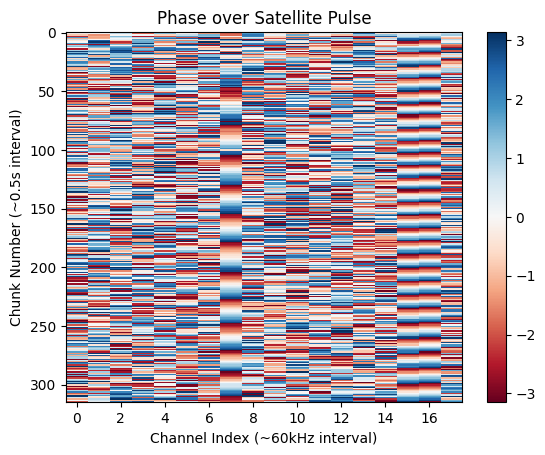

In [536]:
plt.xlabel("Channel Index (~60kHz interval)")
plt.ylabel("Chunk Number (~0.5s interval)")
plt.title("Phase over Satellite Pulse")
plt.imshow(phased_visibility, aspect='auto',cmap='RdBu',interpolation="none")
plt.colorbar()

In [537]:
print("initial number of seconds", times[1]-times[0])
print(channels_present)

initial number of seconds 135
[1849, 1850]


In [539]:
sec_amend = 130
chunk_amend = int(sec_amend/(context[2]*context[1]))
print(chunk_amend)

chan_small = 16
chan_big = int(channel_list[chan_small])
print("big chan idx:", chan_big)

264
big chan idx: 1850


0.0


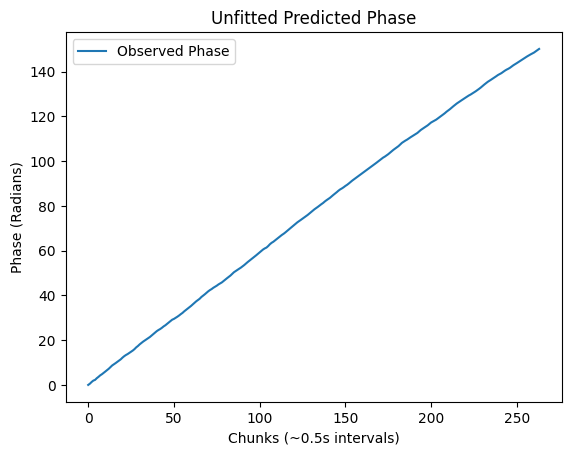

In [540]:
phase_data = np.unwrap(phased_visibility[:chunk_amend , chan_small] - phased_visibility[0 , chan_small])

print(phase_data[0])
plt.plot(phase_data, label="Observed Phase")
plt.xlabel("Chunks (~0.5s intervals)")
plt.ylabel("Phase (Radians)")
plt.title("Unfitted Predicted Phase")
plt.legend()

In [541]:
new_end_time = sec_amend + times[0]

info_dict[label] = [label, [times[0], new_end_time, times[2]], [satID, chan_big], tle_path, phase_data]
print(info_dict[label][0])

9_30745


catalog #33591 epoch 2024-07-24 21:36:39 UTC
catalog #33591 epoch 2024-07-24 21:36:39 UTC
predictor chunk number 264
observed chunk number 63


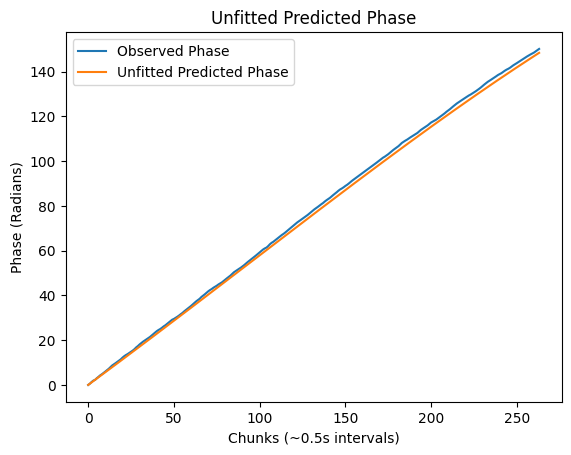

In [542]:
info_pulse = info_dict[label]

plt.plot((info_pulse[4]), label="Observed Phase")
plt.plot(ch.phase_pred(a2_coords, 0, [info_pulse], context), label="Unfitted Predicted Phase")
plt.xlabel("Chunks (~0.5s intervals)")
plt.ylabel("Phase (Radians)")
plt.title("Unfitted Predicted Phase")
plt.legend()

print("predictor chunk number", len(ch.phase_pred(a2_coords, 0, [info_pulse], context)))
print("observed chunk number", len(info_pulse[3]))

In [543]:
#good_idx_set.add(int(label.split('_')[0]))
good_idx_set.add(label)

# 14, 26, 40 a little sus (big gap, 33591)
# 17, 43 also a little sus (again big gap)
# 22 not great

print(good_idx_set)
print(len(good_idx_set))

{'17_38680', '10_31075', '3_9805', '9_30745', '16_37845', '26_55400', '47_85440', '4_13775', '2_7755', '14_36805', '6_24870', '24_52675', '39_72935', '31_61395', '43_79075', '13_34485', '11_31840', '29_58725', '12_32660', '25_54865', '18_40545', '27_55945', '23_50710', '28_56710', '1_3520', '34_64765', '40_73405', '5_19805', '32_62085', '0_0', '44_79415', '46_82975'}
32


In [544]:
good_pulse_data = []
for label, info in info_dict.items():
    if label in good_idx_set:
        good_pulse_data.append(info)

In [545]:
print(len(pulse_data))

48


In [546]:
print(len(good_pulse_data))

32


In [547]:
print(good_pulse_data[1])

['10_31075', [31075, 31355, 1721797200], [25338, 1841], '/project/s/sievers/mohanagr/OCOMM_TLES/2024/202407/20240724.txt', array([ 0.00000000e+00,  3.51269245e-02,  3.94716263e-02,  9.35730934e-02,
        2.42245197e-01,  3.53392124e-01,  3.90675545e-01,  4.32181358e-01,
        4.80735779e-01,  5.66271305e-01,  6.79954529e-01,  7.16396809e-01,
        8.21847200e-01,  8.58305216e-01,  9.29729939e-01,  9.50237274e-01,
        1.04547262e+00,  1.09024954e+00,  1.06794500e+00,  1.11474729e+00,
        1.01826715e+00,  9.47533131e-01,  9.18427467e-01,  8.46588612e-01,
        8.02197933e-01,  7.14792013e-01,  6.99383736e-01,  5.92125416e-01,
        5.53716660e-01,  4.86904860e-01,  4.18845177e-01,  4.06296968e-01,
        3.71929646e-01,  3.97309303e-01,  4.04488802e-01,  4.62481022e-01,
        3.92462015e-01,  3.02317858e-01,  3.07537794e-01,  2.36510515e-01,
        1.54819965e-01,  1.18147135e-01,  3.61490250e-02, -3.50322723e-02,
       -5.22336960e-02, -6.98394775e-02, -2.29033470

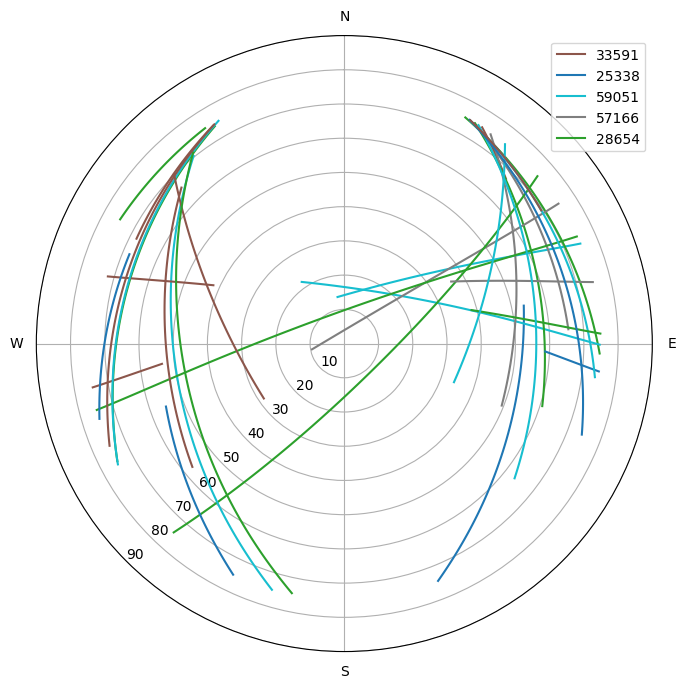

In [548]:
ch.satpass_plotter(good_pulse_data, a2_coords)

In [549]:
with h5py.File(f'{working_directory}/{day}/vis_selected_bline_{baseline_idx}_{global_start_time}.h5', 'w') as f:
    for idx in range(len(good_pulse_data)):
        #name the data after the label
        pulse_array = f.create_dataset(f'{good_pulse_data[idx][0]}', data=good_pulse_data[idx][4])

        pulse_array.attrs['start_time']        = good_pulse_data[idx][1][0]
        pulse_array.attrs['end_time']          = good_pulse_data[idx][1][1]
        pulse_array.attrs['global_start_time'] = good_pulse_data[idx][1][2]
        pulse_array.attrs['sat']               = good_pulse_data[idx][2][0]
        pulse_array.attrs['chan']              = good_pulse_data[idx][2][1]
        pulse_array.attrs['tle_path']          = good_pulse_data[idx][3]

    f.attrs["vis_window"] = visibility_window
    f.attrs["v_acclen"] = v_acclen
    f.attrs["T_SPECTRA"] = V_T_ACCLEN
    f.attrs["v_nchunks"] = v_nchunks
    f.attrs["ref_coords"] = ref_coords #necessary?
    f.attrs["baseline_idx"] = baseline_idx